In [1]:
# Atividade 3 - Seleção de Modelos com teste T

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from utils import do_cv_knn

%matplotlib inline

In [3]:
# Carrega o dataset
df = pd.read_csv('mini_mnist.csv')
df.tail()
# df.shape

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,digito
1495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
1498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import itertools

In [5]:
# Pego os valores as classes e os valores a serem normalizados
y = df['digito'].values
X = df.drop('digito', axis=1)

# normalização
ss = StandardScaler()
ss.fit(X)

X_ss = ss.transform(X)
X = X.values

# Dataframe normalizado
X_ss = pd.DataFrame( np.hstack((X_ss, df['digito'].values.reshape((-1,1)) )), columns=df.columns)
X_ss.tail()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,digito
1495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.035238,-0.037101,-0.030756,0.0,0.0,0.0,0.0,0.0,0.0,7.0
1496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.035238,-0.037101,-0.030756,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.035238,-0.037101,-0.030756,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.035238,-0.037101,-0.030756,0.0,0.0,0.0,0.0,0.0,0.0,9.0
1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.035238,-0.037101,-0.030756,0.0,0.0,0.0,0.0,0.0,0.0,6.0


<AxesSubplot:xlabel='PC 0', ylabel='PC 1'>

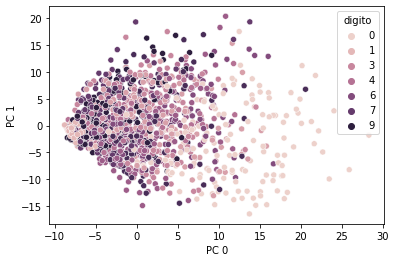

In [6]:
pca = PCA(n_components=2)
X_pca_ss = X_ss.drop('digito', axis=1)

pca.fit(X_pca_ss)
X_pca_ss = pca.transform(X_pca_ss)

X_pca_ss = pd.DataFrame(X_pca_ss, columns=['PC 0', 'PC 1'])

# Mudar paleta de cores
sns.scatterplot(data=X_pca_ss, x='PC 0', y='PC 1', hue=df['digito'])

In [7]:
from joblib import Parallel, delayed

In [8]:
def selecionar_melhor_k(ks, X_treino, X_val, y_treino, y_val):
    acuracias_val = []

    print("Selecionando melhor K")

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_treino, y_treino)
        pred = knn.predict(X_val)
        acuracias_val.append(accuracy_score(y_val, pred))
        
    melhor_val = max(acuracias_val)
    melhor_k = ks[np.argmax(acuracias_val)]        
    knn = KNeighborsClassifier(n_neighbors=melhor_k)
    knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return knn, melhor_k, melhor_val

In [9]:
# Realiza o treinamento para cada hiperparâmetro
def treina_svm(C, gamma, X_treino, X_val, y_treino, y_val):
    svm = SVC(C= C, gamma= gamma)
    svm.fit(X_treino, y_treino)
    pred = svm.predict(X_val)
    return accuracy_score(y_val, pred)

def selecionar_melhor_svm(Cs, gamma,X_treino:np.ndarray, X_val:np.ndarray, y_treino:np.ndarray, y_val:np.ndarray, n_jobs=4):
    acuracias_val_svm = []
    print("Selecionando melhor SVM")
    # cria todas as combinações possíveis entre os Cs e os gammas
    hiperparametros = list(itertools.product(Cs, gamma))
    
    # Treina os modelos utilizando todas as combinações possíveis
    acuracias_val_svm = Parallel(n_jobs= n_jobs)(delayed(treina_svm)
            (c, g, X_treino, X_val, y_treino, y_val) for c, g in hiperparametros)


    melhor_acuracia = max(acuracias_val_svm)
    melhor_combinacao = hiperparametros[np.argmax(acuracias_val_svm)]
    
    svm = SVC(C= melhor_combinacao[0], gamma=melhor_combinacao[1])
    svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])


    return svm, melhor_combinacao[0], melhor_combinacao[1], melhor_acuracia

def treinando_svm_knn():
    # realiza validação cruzada em um nível
    k_vias = 10
    skf = StratifiedKFold(n_splits=k_vias, shuffle=True, random_state=1)
    Cs=[1, 10, 100, 1000]
    gammas=['scale', 'auto', 2e-2, 2e-3, 2e-4]
    i = 0

    pgb = tqdm(total=k_vias, desc='Folds avaliados')
    print("Começando treino em cada fold")

    lista_acuracia_knn = []
    lista_acuracia_svm = []

    for idx_treino, idx_teste in skf.split(X, y):
        print("Fold %d" % i)
        # Separando cada fold em treino e teste
        X_treino = X[idx_treino]
        y_treino = y[idx_treino]

        X_teste = X[idx_teste]
        y_teste = y[idx_teste]

        # Separando o conjunto de treino em validação e treino
        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify= y_treino, random_state=1)

        # Normaliza cada partição
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_val = ss.transform(X_val)
        X_teste = ss.transform(X_teste)

        # Otimizando hiperparâmetro do knn
        knn, _, _ = selecionar_melhor_k(range(1,30,2), X_treino, X_val, y_treino, y_val)
        svm, _, _, _ = selecionar_melhor_svm(Cs, gammas,X_treino, X_val, y_treino, y_val)

        # Apartir do melhor modelo treinado do knn e do svm realizo a predição
        pred_svm = svm.predict(X_teste)
        pred_knn = knn.predict(X_teste)

        # Utilizo a acurácia como medida para avaliar o classificador
        acuracia_knn = accuracy_score(y_teste, pred_knn)
        acuracia_svm = accuracy_score(y_teste, pred_svm)

        lista_acuracia_knn.append(acuracia_knn)
        lista_acuracia_svm.append(acuracia_svm)
        print("Acurácia SVM: %.2f" % (acuracia_svm))
        print("Acurácia KNN: %.2f" % (acuracia_knn))

        # 
        pgb.update(1)
        i += 1

    pgb.close()
    print("Desvio KNN: %.2f +- %.2f Acurácia Max KNN: %.2f Acurárcia Min KNN: %.2f" % (np.mean(lista_acuracia_knn), np.std(lista_acuracia_knn), max(lista_acuracia_knn), min(lista_acuracia_knn)))
    print("Desvio SVM: %.2f +- %.2f Acurácia Max SVM: %.2f Acurárcia Min SVM: %.2f" % (np.mean(lista_acuracia_svm), np.std(lista_acuracia_svm), max(lista_acuracia_svm), min(lista_acuracia_svm)))
    return lista_acuracia_knn, lista_acuracia_svm

In [10]:
knn_acuracias, svm_acuracias = treinando_svm_knn()

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Começando treino em cada fold
Fold 0
Selecionando melhor K
Selecionando melhor SVM
Acurácia SVM: 0.87
Acurácia KNN: 0.80
Fold 1
Selecionando melhor K
Selecionando melhor SVM
Acurácia SVM: 0.90
Acurácia KNN: 0.89
Fold 2
Selecionando melhor K
Selecionando melhor SVM
Acurácia SVM: 0.86
Acurácia KNN: 0.83
Fold 3
Selecionando melhor K
Selecionando melhor SVM
Acurácia SVM: 0.87
Acurácia KNN: 0.83
Fold 4
Selecionando melhor K
Selecionando melhor SVM
Acurácia SVM: 0.91
Acurácia KNN: 0.81
Fold 5
Selecionando melhor K
Selecionando melhor SVM
Acurácia SVM: 0.84
Acurácia KNN: 0.82
Fold 6
Selecionando melhor K
Selecionando melhor SVM
Acurácia SVM: 0.88
Acurácia KNN: 0.83
Fold 7
Selecionando melhor K
Selecionando melhor SVM
Acurácia SVM: 0.85
Acurácia KNN: 0.85
Fold 8
Selecionando melhor K
Selecionando melhor SVM
Acurácia SVM: 0.88
Acurácia KNN: 0.87
Fold 9
Selecionando melhor K
Selecionando melhor SVM
Acurácia SVM: 0.88
Acurácia KNN: 0.85
Desvio KNN: 0.84 +- 0.03 Acurácia Max KNN: 0.89 Acurárcia Mi

# Aplicando Teste T de Student

É possível perceber acima que as acurácias médias do KNN e do SVM são diferentes, onde pode se esperar, para dados desconhecidos, uma acurácia média entre 0.81 e 0.87 para o classificador SVM e uma acurácia entre 0.86 e 0.90. Podemos notar que há uma pequena sobreposição entre as acurárias, mas a pergunta que deve ser realmente feita é, embora as acurácias sejam diferentes, elas são significativamente significantes, ou seja, é possível negar a hipótese nula que diz que não há diferença entre as duas distribuições.
Será utilizado um alfa de 0.05, que é o valor mínimo que será aceito para rejeitar a hipótese nula, ou seja, será possível dizer com 95% de certeza que a diferença entre as duas distribuições é significativa.

In [11]:
# Calcula os valores de p-value
from scipy.stats import ttest_ind_from_stats

In [12]:
def calcula_media_std(acuracia_classificador):
    return np.mean(acuracia_classificador), np.std(acuracia_classificador)

In [14]:
media_knn, std_knn = calcula_media_std(knn_acuracias)
media_svm, std_svm = calcula_media_std(svm_acuracias)

print(media_knn, std_knn)
print(media_svm, std_svm)

0.8379999999999999 0.02565584187319181
0.8753333333333334 0.020231987873991362


In [18]:
# Calcula p-value
_, pvalor = ttest_ind_from_stats(media_svm, std_svm, len(svm_acuracias), media_knn, std_knn, len(knn_acuracias))
print("P-Value %.4f -- A hipótese nula é %s" % (pvalor, pvalor<=0.05))


P-Value 0.0020 -- A hipótese nula é True


Como foi possível rejeitar a hipótese nula, podemos afirmar que a diferença nos resultados da média é significativa entre os dois classificadores, já que o valor de p-value foi menor do que 0.05